# Signal Loss

In [42]:
import numpy as n
import matplotlib.pyplot as plt
import matplotlib
import capo

### FUNCTIONS ###

def get_PS(DATA, EoR, FG, use_cov_DATA=False, use_cov_EoR=False, use_cov_FG=False):
    ds_DATA = DataSet()
    ds_DATA.set_data(dsets = {'DATA': DATA.T})
    q_DATA = ds_DATA.q_hat('DATA','DATA', use_cov=use_cov_DATA, cov_flagging=False)
    F_DATA = ds_DATA.get_F('DATA','DATA', use_cov=use_cov_DATA, cov_flagging=False)
    M_DATA,W_DATA = ds_DATA.get_MW(F_DATA, mode='I')
    p_DATA = ds_DATA.p_hat(M_DATA,q_DATA)

    ds_EoR = DataSet()
    ds_EoR.set_data(dsets = {'EoR': EoR.T})
    q_EoR = ds_EoR.q_hat('EoR','EoR', use_cov=use_cov_EoR, cov_flagging=False)
    F_EoR = ds_EoR.get_F('EoR','EoR', use_cov=use_cov_EoR, cov_flagging=False)
    M_EoR,W_EoR = ds_EoR.get_MW(F_EoR, mode='I')
    p_EoR = ds_EoR.p_hat(M_EoR,q_EoR)

    ds_FG = DataSet()
    ds_FG.set_data(dsets = {'FG': FG.T})
    q_FG = ds_FG.q_hat('FG','FG', use_cov=use_cov_FG, cov_flagging=False)
    F_FG = ds_FG.get_F('FG','FG', use_cov=use_cov_FG, cov_flagging=False)
    M_FG,W_FG = ds_FG.get_MW(F_FG, mode='I')
    p_FG = ds_FG.p_hat(M_FG,q_FG)
    
    return p_DATA, p_EoR, p_FG

# Simple Foreground + EoR

In [43]:
times = 100
freqs = 20
n.random.seed(100) # for reproducibility

# Create fake simple foreground
FG = []
for t in range(times):
    sine = n.exp(2j*n.pi*(n.linspace(0,n.pi*2,freqs)+t/100.))*5
    FG.append(sine)
FG = n.array(FG).T

# Create fake EoR
EoR = capo.oqe.noise((freqs, times))

# Add them together
DATA = FG + EoR

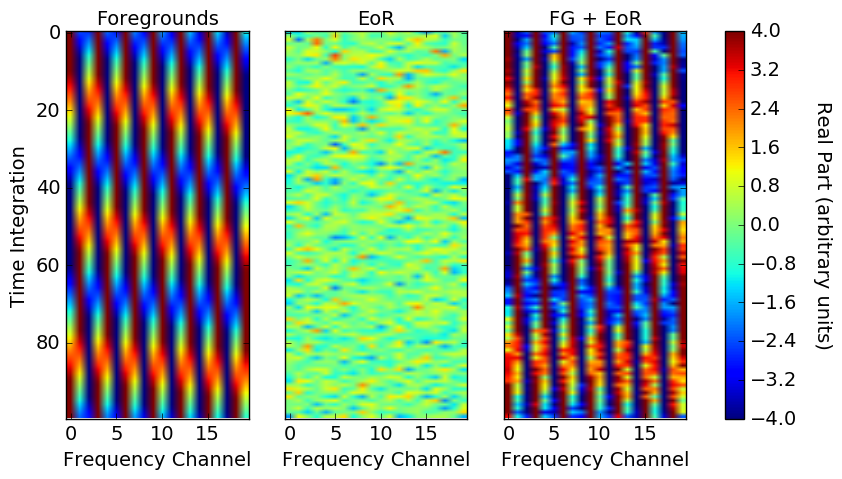

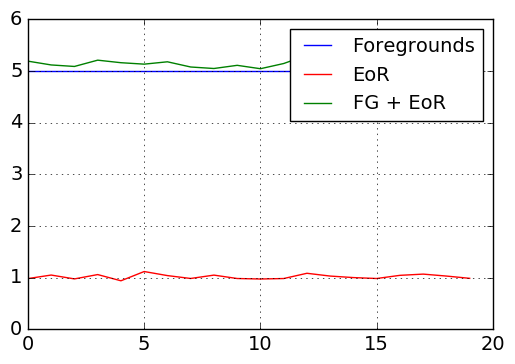

In [44]:
# Plot the signals
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
(ax1,ax2,ax3) = axes
#plt.subplot(131)
ax1.imshow(FG.T.real, aspect='auto', vmax=4, vmin=-4)
ax1.set_ylabel('Time Integration', fontsize=14)
ax1.set_xlabel('Frequency Channel', fontsize=14)
ax1.set_title("Foregrounds", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
#plt.subplot(132)
ax2.imshow(EoR.T.real, aspect='auto', vmax=4, vmin=-4)
#plt.ylabel('Time Integration')
ax2.set_xlabel('Frequency Channel', fontsize=14)
ax2.set_title("EoR", fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
#plt.subplot(133)
im = ax3.imshow(DATA.T.real, aspect='auto', vmax=4, vmin=-4)
#plt.ylabel('Time Integration')
ax3.set_xlabel('Frequency Channel', fontsize=14)
ax3.set_title("FG + EoR", fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
cbar = fig.colorbar(im,ax=[ax1,ax2,ax3])
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Real Part (arbitrary units)', rotation=270, labelpad=25, fontsize=14)
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss1.pdf',bbox_inches='tight')
plt.show()

# Plot the levels
plt.plot(n.sqrt(n.mean(n.abs(FG)**2, axis=1)), 'b-', label='Foregrounds')
plt.plot(n.sqrt(n.mean(n.abs(EoR)**2, axis=1)), 'r-', label='EoR')
plt.plot(n.sqrt(n.mean(n.abs(DATA)**2, axis=1)), 'g-', label='FG + EoR')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(prop={'size':14})
plt.grid()
plt.show()

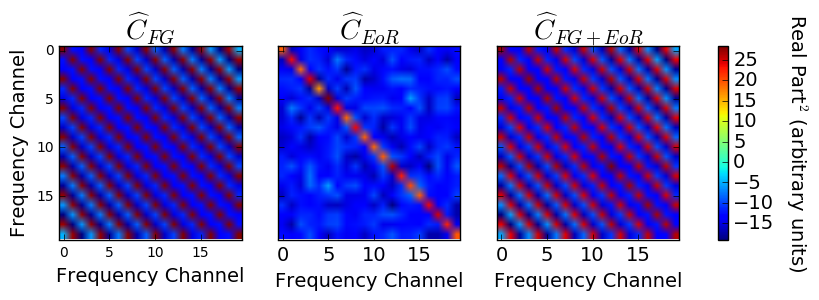

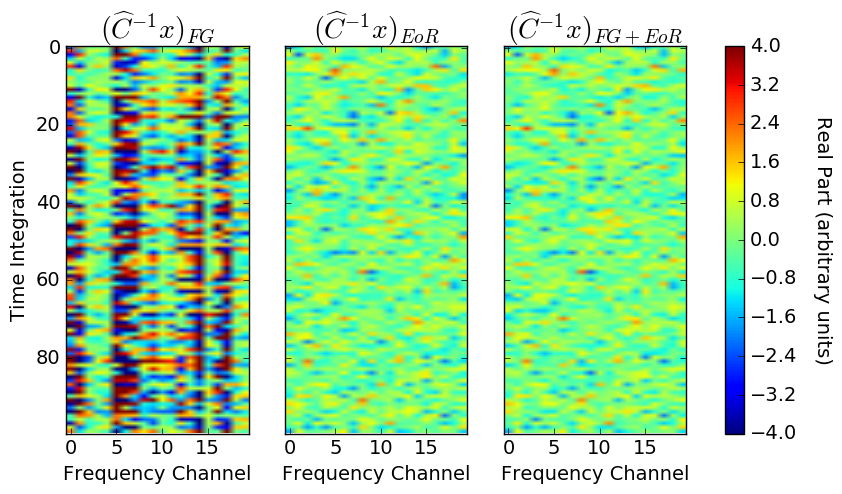

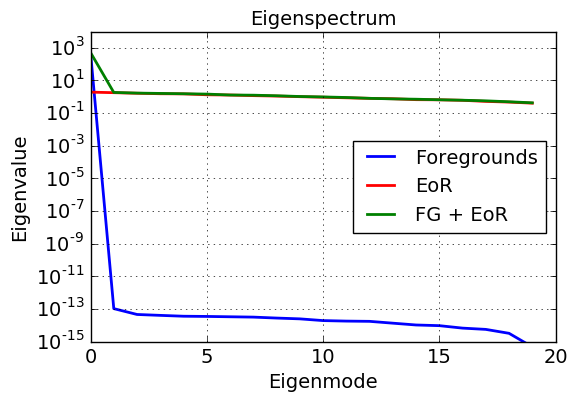

In [45]:
# Get covariance matrices
wgts = n.ones_like(FG)
C_FG = capo.oqe.cov(FG,wgts)
C_EoR = capo.oqe.cov(EoR,wgts)
C_DATA = capo.oqe.cov(DATA,wgts)
U_FG,S_FG,V_FG = n.linalg.svd(n.conj(C_FG))
U_EoR,S_EoR,V_EoR = n.linalg.svd(n.conj(C_EoR))
U_DATA,S_DATA,V_DATA = n.linalg.svd(n.conj(C_DATA))
iC_FG = n.einsum('ij,j,jk', V_FG.T, 1./S_FG, U_FG.T)
iC_EoR = n.einsum('ij,j,jk', V_EoR.T, 1./S_EoR, U_EoR.T)
iC_DATA = n.einsum('ij,j,jk', V_DATA.T, 1./S_DATA, U_DATA.T)
iCx_FG = n.dot(iC_FG,FG)
iCx_EoR = n.dot(iC_EoR,EoR)
iCx_DATA = n.dot(iC_DATA,DATA)
C_DATA_orig = C_DATA

# Plot C's and iCx's
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_figheight(2.5)
fig.set_figwidth(10)
(ax1,ax2,ax3) = axes
ax1.imshow(C_FG.real,aspect='auto')
ax1.set_ylabel('Frequency Channel', fontsize=14)
ax1.set_xlabel('Frequency Channel', fontsize=14)
ax1.set_title("$\widehat{C}_{FG}$", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.imshow(C_EoR.real,aspect='auto')
ax2.set_xlabel('Frequency Channel', fontsize=14)
ax2.set_title("$\widehat{C}_{EoR}$", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=14)
im = ax3.imshow(C_DATA.real,aspect='auto')
ax3.set_xlabel('Frequency Channel', fontsize=14)
ax3.set_title("$\widehat{C}_{FG + EoR}$", fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=14)
cbar = fig.colorbar(im,ax=[ax1,ax2,ax3])
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Real Part$^{2}$ (arbitrary units)', rotation=270, labelpad=25, fontsize=14)
#plt.tight_layout()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss12.pdf',bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
(ax1,ax2,ax3) = axes
ax1.imshow(iCx_FG.real.T, aspect='auto', vmax=4, vmin=-4)
ax1.set_ylabel('Time Integration', fontsize=14)
ax1.set_xlabel('Frequency Channel', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_title("$(\widehat{C}^{-1}x)_{FG}$", fontsize=20)
ax2.imshow(iCx_EoR.real.T, aspect='auto', vmax=4, vmin=-4)
ax2.set_xlabel('Frequency Channel', fontsize=14)
ax2.set_title("$(\widehat{C}^{-1}x)_{EoR}$", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=14)
im = ax3.imshow(iCx_DATA.real.T, aspect='auto', vmax=4, vmin=-4)
ax3.set_xlabel('Frequency Channel', fontsize=14)
ax3.set_title("$(\widehat{C}^{-1}x)_{FG + EoR}$", fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=14)
cbar = fig.colorbar(im,ax=[ax1,ax2,ax3])
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Real Part (arbitrary units)', rotation=270, labelpad=25, fontsize=14)
#plt.tight_layout()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss13.pdf',bbox_inches='tight')
plt.show()

# Plot eigenspectrums
plt.semilogy(S_FG, 'b-', linewidth=2, label='Foregrounds')
plt.semilogy(S_EoR, 'r-', linewidth=2, label='EoR')
plt.semilogy(S_DATA, 'g-', linewidth=2, label='FG + EoR')
plt.title("Eigenspectrum", fontsize=14)
plt.xlabel('Eigenmode', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xlim(0,10)
plt.ylim(1e-15,1e4)
plt.legend(prop={'size':14},loc='best')
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss2.pdf',bbox_inches='tight')
plt.show()
S_NOFRF_DATA = S_DATA
S_NOFRF_FG = S_FG
S_NOFRF_EOR = S_EoR

# Full Covariance Weighting: Some Signal Loss

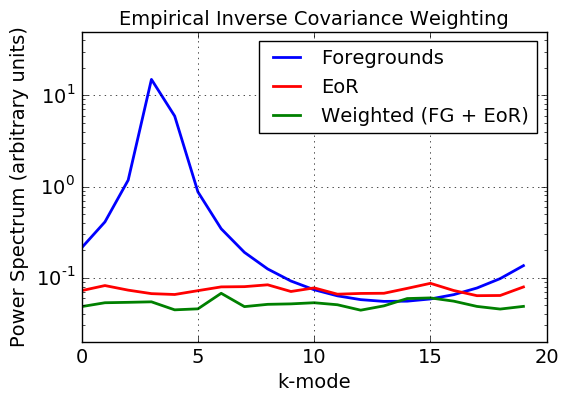

In [46]:
# Use OQE Module
class DataSet(capo.oqe.DataSet):
    def iC(self, k, t=None, rcond=1e-12):
        assert(t == None)
        if not self._iC.has_key(k):
            C = self.C(k)
            U,S,V = n.linalg.svd(C.conj()) # conj in advance of next step
            iS = 1./S
            self.set_iC({k:n.einsum('ij,j,jk', V.T, iS, U.T)})
        return self._iC[k]
    
p_DATA, p_EoR, p_FG = get_PS(DATA, EoR, FG, True, False, False)

# Plot the levels
plt.semilogy(n.sqrt(n.mean(n.abs(p_FG)**2, axis=1)), 'b-', label='Foregrounds', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_EoR)**2, axis=1)), 'r-', label='EoR', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA)**2, axis=1)), 'g-', label='Weighted (FG + EoR)', linewidth=2)
plt.ylabel('Power Spectrum (arbitrary units)', fontsize=14)
plt.xlabel('k-mode', fontsize=14)
plt.legend(prop={'size':14},loc='best')
plt.title('Empirical Inverse Covariance Weighting', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(0.2e-1,5e1)
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss3.pdf',bbox_inches='tight')
plt.show()

# Only Use First Eigenmode: No Signal Loss

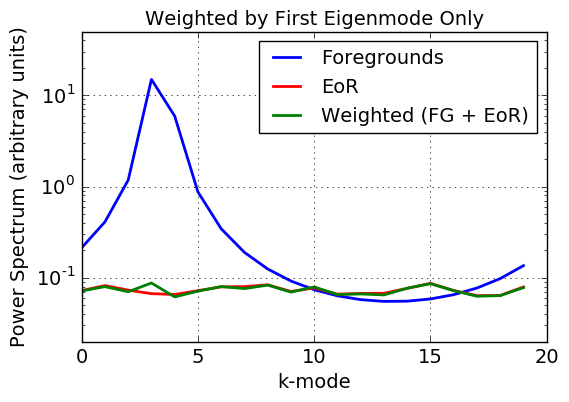

In [47]:
class DataSet(capo.oqe.DataSet):
    def iC(self, k, t=None, rcond=1e-12):
        assert(t == None)
        if not self._iC.has_key(k):
            C = self.C(k)
            U,S,V = n.linalg.svd(C.conj()) # conj in advance of next step
            iS = 1./S
            iS[1:] = 1.0 # Only use first eigenmode
            self.set_iC({k:n.einsum('ij,j,jk', V.T, iS, U.T)})
        return self._iC[k]

p_DATA, p_EoR, p_FG = get_PS(DATA, EoR, FG, True, False, False)

# Plot the levels
plt.semilogy(n.sqrt(n.mean(n.abs(p_FG)**2, axis=1)), 'b-', label='Foregrounds', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_EoR)**2, axis=1)), 'r-', label='EoR', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA)**2, axis=1)), 'g-', label='Weighted (FG + EoR)', linewidth=2)
plt.ylabel('Power Spectrum (arbitrary units)', fontsize=14)
plt.xlabel('k-mode', fontsize=14)
plt.legend(prop={'size':14},loc='best')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(0.2e-1,5e1)
plt.title('Weighted by First Eigenmode Only', fontsize=14)
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss4.pdf',bbox_inches='tight')
plt.show()

# FRF Case

In [48]:
times = 100
freqs = 20
import numpy as n
import capo
import matplotlib.pyplot as plt

# Create fake simple foreground (SAME AS FIRST EXAMPLE)
FG = []
for t in range(times):
    sine = n.exp(2j*n.pi*(n.linspace(0,n.pi*2,freqs)+t/100.))*5
    FG.append(sine)
FG = n.array(FG).T

# Create fake EoR
EoR = capo.oqe.noise((freqs, times))

# Add them together
DATA = FG + EoR

# Average in time
N = 25 # number of independent samples
EoR = EoR[:,:times/(times/N)]
EoR = n.repeat(EoR,(times/N),axis=1)
FG = FG[:,:times/(times/N)]
FG = n.repeat(FG,(times/N),axis=1)

# Add them together
DATA = FG + EoR

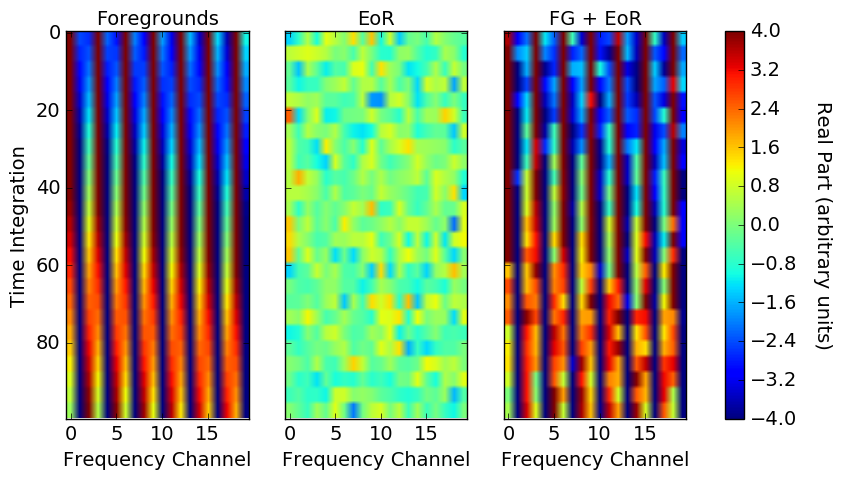

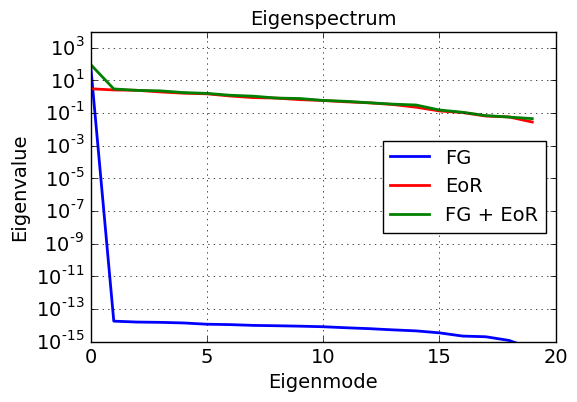

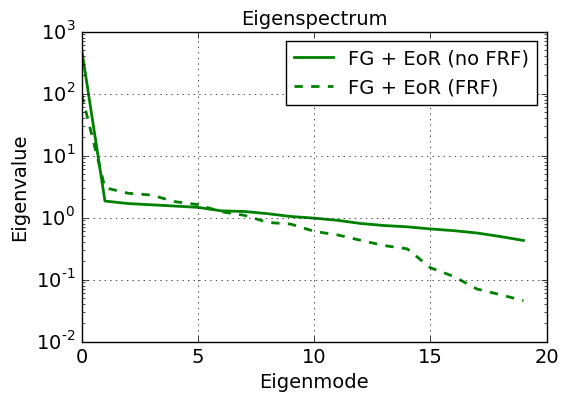

In [17]:
# Plot the signals
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
(ax1,ax2,ax3) = axes
#plt.subplot(131)
ax1.imshow(FG.T.real, aspect='auto', vmax=4, vmin=-4)
ax1.set_ylabel('Time Integration', fontsize=14)
ax1.set_xlabel('Frequency Channel',fontsize=14)
ax1.set_title("Foregrounds",fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
#plt.subplot(132)
ax2.imshow(EoR.T.real, aspect='auto', vmax=4, vmin=-4)
#plt.ylabel('Time Integration')
ax2.set_xlabel('Frequency Channel',fontsize=14)
ax2.set_title("EoR",fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
#plt.subplot(133)
im = ax3.imshow(DATA.T.real, aspect='auto', vmax=4, vmin=-4)
#plt.ylabel('Time Integration')
ax3.set_xlabel('Frequency Channel',fontsize=14)
ax3.set_title("FG + EoR",fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
cbar = fig.colorbar(im,ax=[ax1,ax2,ax3])
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Real Part (arbitrary units)', rotation=270, labelpad=25, fontsize=14)
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss5.pdf',bbox_inches='tight')
plt.show()

# Get covariance matrices
wgts = n.ones_like(FG)
C_FG = capo.oqe.cov(FG,wgts)
C_EoR = capo.oqe.cov(EoR,wgts)
C_DATA = capo.oqe.cov(DATA,wgts)
U_FG,S_FG,V_FG = n.linalg.svd(n.conj(C_FG))
U_EoR,S_EoR,V_EoR = n.linalg.svd(n.conj(C_EoR))
U_DATA,S_DATA,V_DATA = n.linalg.svd(n.conj(C_DATA))
C_DATA_FRF_orig = C_DATA

# Plot eigenspectrums
plt.semilogy(S_FG, 'b-', label='FG', linewidth=2)
plt.semilogy(S_EoR, 'r-', label='EoR', linewidth=2)
plt.semilogy(S_DATA,'g-',label='FG + EoR', linewidth=2)
#plt.semilogy(S_NOFRF_FG, 'b--', label='FG (no FRF)')
#plt.semilogy(S_NOFRF_EOR, 'r--', label='EoR (no FRF)')
#plt.semilogy(S_NOFRF_DATA,'g--',label='FG + EoR (no FRF)')
plt.title("Eigenspectrum", fontsize=14)
plt.xlabel('Eigenmode', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(1e-15,1e4)
#plt.xlim(0,10)
plt.legend(prop={'size':14},loc='best',numpoints=1)
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss6.pdf',bbox_inches='tight')
plt.show()

plt.semilogy(S_NOFRF_DATA,'g-',label='FG + EoR (no FRF)', linewidth=2)
plt.semilogy(S_DATA,'g--',label='FG + EoR (FRF)', linewidth=2)
plt.title("Eigenspectrum", fontsize=14)
plt.xlabel('Eigenmode',fontsize=14)
plt.ylabel('Eigenvalue',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ylim(1e-15,1e4)
#plt.xlim(0,10)
plt.legend(prop={'size':14},loc='best',numpoints=1)
plt.grid()
plt.ylim(1e-2,1e3)
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss15.pdf',bbox_inches='tight')
plt.show()

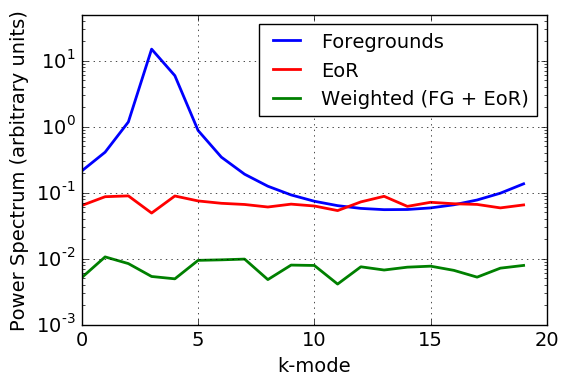

In [49]:
class DataSet(capo.oqe.DataSet):
    def iC(self, k, t=None, rcond=1e-12):
        assert(t == None)
        if not self._iC.has_key(k):
            C = self.C(k)
            U,S,V = n.linalg.svd(C.conj()) # conj in advance of next step
            iS = 1./S
            #iS[:2] = 0.0
            self.set_iC({k:n.einsum('ij,j,jk', V.T, iS, U.T)})
        return self._iC[k]

p_DATA, p_EoR, p_FG = get_PS(DATA, EoR, FG, True, False, False)
p_DATA_I,_,_ = get_PS(DATA, EoR, FG, False, False, False)

# Plot the levels
plt.semilogy(n.sqrt(n.mean(n.abs(p_FG)**2, axis=1)), 'b-', label='Foregrounds', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_EoR)**2, axis=1)), 'r-', label='EoR', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA)**2, axis=1)), 'g-', label='Weighted (FG + EoR)', linewidth=2)
#plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA_I)**2, axis=1)), 'g--', label='Unweighted (FG + EoR)')
plt.xlabel('k-mode', fontsize=14)
plt.ylabel('Power Spectrum (arbitrary units)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(prop={'size':14},loc='best')
plt.ylim(1e-3,5e1)
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss7.pdf',bbox_inches='tight')
#plt.ylim(1e-3,1e2)
plt.show() 
# noisier estimate because most of our information comes from the last few modes now
# lossier estimate because we have fewer independent samples

# Inverse Variance Weighting

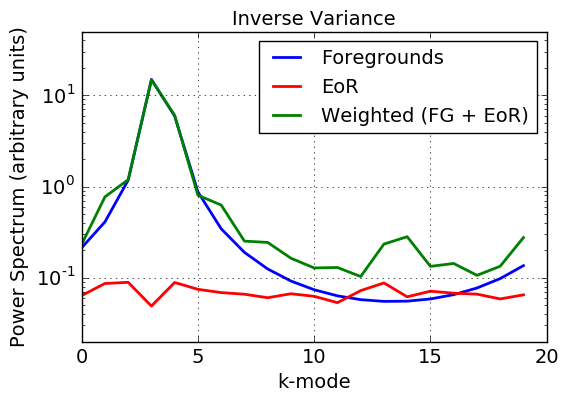

In [50]:
class DataSet(capo.oqe.DataSet):
    def iC(self, k, t=None, rcond=1e-12):
        assert(t == None)
        if not self._iC.has_key(k):
            C = self.C(k) 
            C *= n.identity(C.shape[0]) # multiply by identity for inverse variance weighting
            U,S,V = n.linalg.svd(C.conj()) # conj in advance of next step
            iS = 1./S
            self.set_iC({k:n.einsum('ij,j,jk', V.T, iS, U.T)})
        return self._iC[k]

p_DATA, p_EoR, p_FG = get_PS(DATA, EoR, FG, True, False, False)

# Plot the levels
plt.semilogy(n.sqrt(n.mean(n.abs(p_FG)**2, axis=1)), 'b-', label='Foregrounds', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_EoR)**2, axis=1)), 'r-', label='EoR', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA)**2, axis=1)), 'g-', label='Weighted (FG + EoR)', linewidth=2)
plt.ylim(0.2e-1,5e1)
plt.xlabel('k-mode', fontsize=14)
plt.ylabel('Power Spectrum (arbitrary units)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(prop={'size':14},loc='best')
plt.grid()
plt.title('Inverse Variance', fontsize=14)
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss11.pdf',bbox_inches='tight')
plt.show() 
# inverse variance weighting doesn't work so well here
# but in the case of when we have very little few modes, it does basically the same thing as adding an identity

# Adding Identity

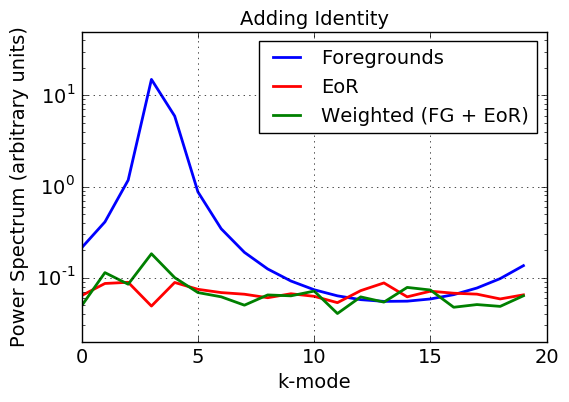

In [51]:
class DataSet(capo.oqe.DataSet):
    def iC(self, k, t=None, rcond=1e-12):
        assert(t == None)
        if not self._iC.has_key(k):
            C = self.C(k) 
            C += n.identity(C.shape[0])*5 # add identity
            U,S,V = n.linalg.svd(C.conj()) # conj in advance of next step
            iS = 1./S
            self.set_iC({k:n.einsum('ij,j,jk', V.T, iS, U.T)})
        return self._iC[k]

p_DATA, p_EoR, p_FG = get_PS(DATA, EoR, FG, True, False, False)

# Plot the levels
plt.semilogy(n.sqrt(n.mean(n.abs(p_FG)**2, axis=1)), 'b-', label='Foregrounds', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_EoR)**2, axis=1)), 'r-', label='EoR', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA)**2, axis=1)), 'g-', label='Weighted (FG + EoR)', linewidth=2)
plt.ylim(0.2e-1,5e1)
plt.ylabel('Power Spectrum (arbitrary units)', fontsize=14)
plt.xlabel('k-mode', fontsize=14)
plt.title('Adding Identity', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(prop={'size':14},loc='best')
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss8.pdf',bbox_inches='tight')
plt.show() 

# Only First Few Eigenmodes

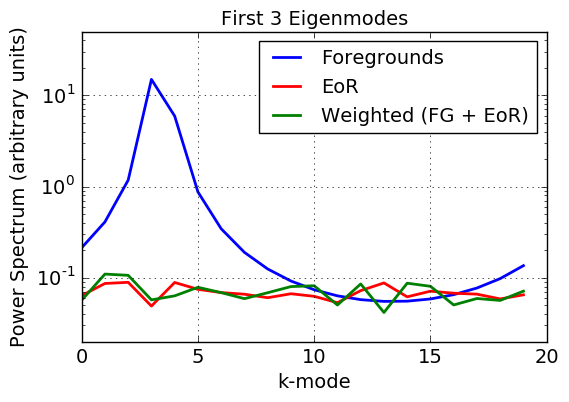

In [52]:
class DataSet(capo.oqe.DataSet):
    def iC(self, k, t=None, rcond=1e-12):
        assert(t == None)
        if not self._iC.has_key(k):
            C = self.C(k) 
            U,S,V = n.linalg.svd(C.conj()) # conj in advance of next step
            iS = 1./S
            iS[2:] = 1.0 # only use first few eigenmodes (to down-weight FG)
            self.set_iC({k:n.einsum('ij,j,jk', V.T, iS, U.T)})
        return self._iC[k]

p_DATA, p_EoR, p_FG = get_PS(DATA, EoR, FG, True, False, False)

# Plot the levels
plt.semilogy(n.sqrt(n.mean(n.abs(p_FG)**2, axis=1)), 'b-', label='Foregrounds', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_EoR)**2, axis=1)), 'r-', label='EoR', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA)**2, axis=1)), 'g-', label='Weighted (FG + EoR)', linewidth=2)
plt.ylim(0.2e-1,5e1)
plt.ylabel('Power Spectrum (arbitrary units)', fontsize=14)
plt.xlabel('k-mode', fontsize=14)
plt.title('First 3 Eigenmodes', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(prop={'size':14},loc='best')
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss9.pdf',bbox_inches='tight')
plt.show() 

# Modeling: no signal loss if C_EoR is estimated not on EoR itself

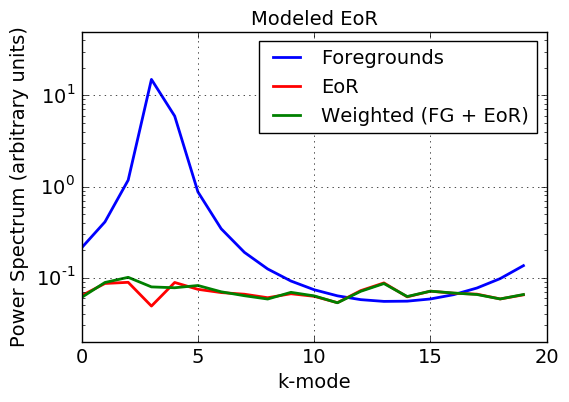

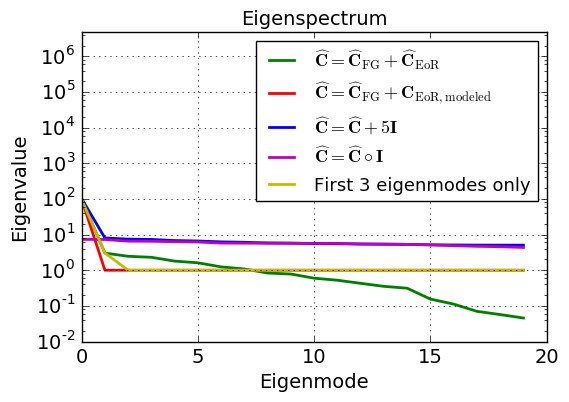

In [55]:
C_FG_new = capo.oqe.cov(FG,wgts)
C_EoR_new = n.identity(C_FG_new.shape[0]) # identity for pure noise with variance 1
C_DATA_new = C_FG_new + C_EoR_new 

class DataSet(capo.oqe.DataSet):
    def iC(self, k, t=None, rcond=1e-12):
        assert(t == None)
        if not self._iC.has_key(k):
            C = self.C(k)
            C = C_DATA_new # over-ride 
            U,S,V = n.linalg.svd(C.conj()) # conj in advance of next step
            iS = 1./S
            self.set_iC({k:n.einsum('ij,j,jk', V.T, iS, U.T)})
        return self._iC[k]

p_DATA, p_EoR, p_FG = get_PS(DATA, EoR, FG, True, False, False)

# Plot the levels
plt.semilogy(n.sqrt(n.mean(n.abs(p_FG)**2, axis=1)), 'b-', label='Foregrounds', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_EoR)**2, axis=1)), 'r-', label='EoR', linewidth=2)
plt.semilogy(n.sqrt(n.mean(n.abs(p_DATA)**2, axis=1)), 'g-', label='Weighted (FG + EoR)', linewidth=2)
plt.ylim(0.2e-1,5e1)
plt.ylabel('Power Spectrum (arbitrary units)', fontsize=14)
plt.xlabel('k-mode', fontsize=14)
plt.title('Modeled EoR', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(prop={'size':14},loc='best')
plt.grid()
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss10.pdf',bbox_inches='tight')
plt.show()

# Plot eigenspectrums of regularization methods
C_DATA = capo.oqe.cov(DATA,wgts)
U_DATA,S_DATA,V_DATA = n.linalg.svd(n.conj(C_DATA))
plt.plot(S_DATA,'g-', label='$\widehat{\mathbf{C}} = \widehat{\mathbf{C}}_{\mathrm{FG}} + \widehat{\mathbf{C}}_{\mathrm{EoR}}$', linewidth=2)
C_DATA_1 = C_DATA_new
U_DATA_1,S_DATA_1,V_DATA_1 = n.linalg.svd(n.conj(C_DATA_1))
plt.plot(S_DATA_1,'r-', label='$\widehat{\mathbf{C}} = \widehat{\mathbf{C}}_{\mathrm{FG}} + \mathbf{C}_{\mathrm{EoR, modeled}}$', linewidth=2)
C_DATA_2 = C_DATA + n.identity(C_DATA.shape[0])*5
U_DATA_2,S_DATA_2,V_DATA_2 = n.linalg.svd(n.conj(C_DATA_2))
plt.plot(S_DATA_2,'b-', label='$\widehat{\mathbf{C}} = \widehat{\mathbf{C}} + 5\mathbf{I}$', linewidth=2)
C_DATA_4 = C_DATA * n.identity(C_DATA.shape[0])
U_DATA_4,S_DATA_4,V_DATA_4 = n.linalg.svd(n.conj(C_DATA_4))
plt.plot(S_DATA_4,'m-', label='$\widehat{\mathbf{C}} = \widehat{\mathbf{C}} \circ \mathbf{I}$', linewidth=2)
C_DATA_3 = C_DATA
U_DATA_3,S_DATA_3,V_DATA_3 = n.linalg.svd(n.conj(C_DATA_3))
S_DATA_3[2:] = 1
plt.plot(S_DATA_3,'y-', label='First 3 eigenmodes only', linewidth=2)
plt.ylabel('Eigenvalue', fontsize=14)
plt.xlabel('Eigenmode', fontsize=14)
plt.title('Eigenspectrum', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid();plt.yscale('log');plt.ylim(1e-2,5e6);plt.legend(prop={'size':13},loc='best')
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss14.pdf',bbox_inches='tight')
plt.show()

# Convergence of Estimated Covariances to True Covariances

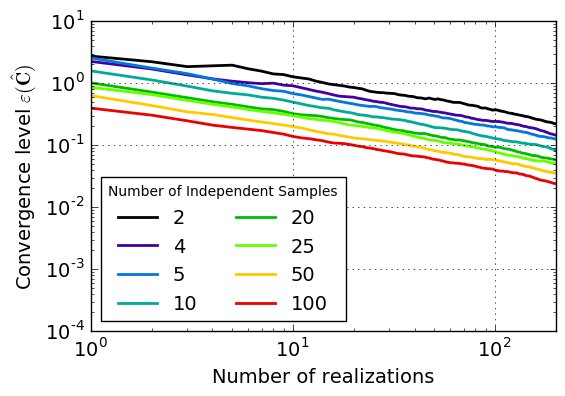

In [24]:
# How does the number of independent samples affect convergence?
import pylab as p
import random
times = 100
freqs = 20
seed=10
N_r = 500 # number of realizations
random.seed(seed)
n.random.seed(seed)

num_colors = 8 # XXX hard-coded
cm = p.get_cmap('nipy_spectral')
color_cnt = 0

for NN,N_ind in enumerate((n.arange(1,101,1))): # number of independent samples
    if times%N_ind != 0: continue # only if number of times is divisible by number of independent samples
    if N_ind == 1: continue
    C_combine_FRF = []
    C_final_FRF = []
    for r in range(N_r):
        EoR = capo.oqe.noise((freqs,times)) # new realization
        wgts = n.ones_like(EoR)
        EoR_FRF = EoR[:,:times/(times/N_ind)]
        EoR_FRF = n.repeat(EoR_FRF,(times/N_ind),axis=1)
        C_DATA_FRF = capo.oqe.cov(EoR_FRF,wgts)
        C_combine_FRF.append(C_DATA_FRF.flatten())
        if r > 0: 
            C_next_FRF = n.mean(C_combine_FRF,axis=0)
            C_final_FRF.append(C_next_FRF)
        else:
            C_final_FRF.append(C_DATA_FRF.flatten())
    C_final_FRF = n.array(C_final_FRF)
    diffs_FRF = []
    true_C = (C_final_FRF[-1,:]).flatten()
    for r in range(N_r):
        diff_FRF = n.linalg.norm(true_C - C_final_FRF[r,:])/n.linalg.norm(true_C)
        diffs_FRF.append(diff_FRF)
    color = cm(1.*color_cnt/num_colors)
    plt.plot(n.arange(1,N_r+1,1),diffs_FRF,linestyle='-',color=color,label=N_ind, linewidth=2)
    color_cnt += 1
plt.xlabel("Number of realizations", fontsize=14)
plt.ylabel(r"Convergence level $\varepsilon(\hat\mathbf{{C}})$", fontsize=14)
plt.legend(prop={'size':14},numpoints=1,loc='best',ncol=2,title="Number of Independent Samples")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(1,200)
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss16.pdf',bbox_inches='tight') # manual save so labels don't get cut off??
plt.show()

# Convergence of Weak vs. Strong Eigenmodes

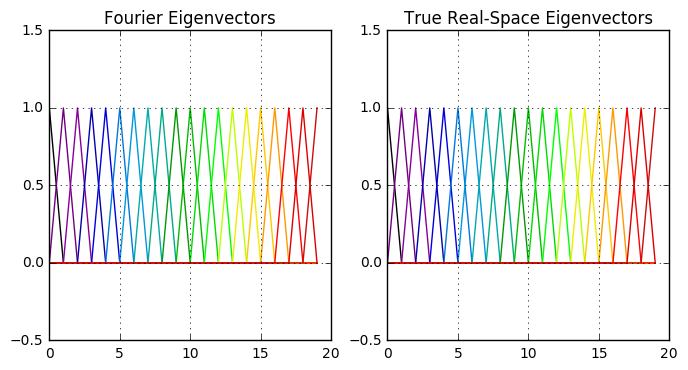

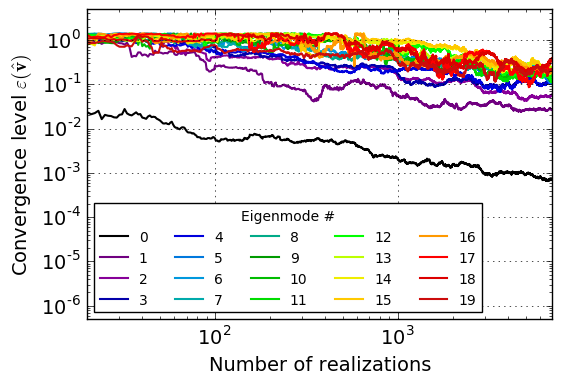

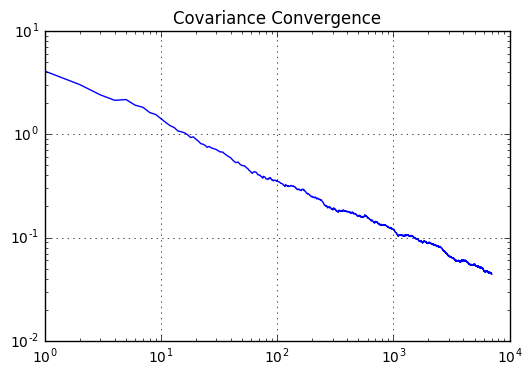

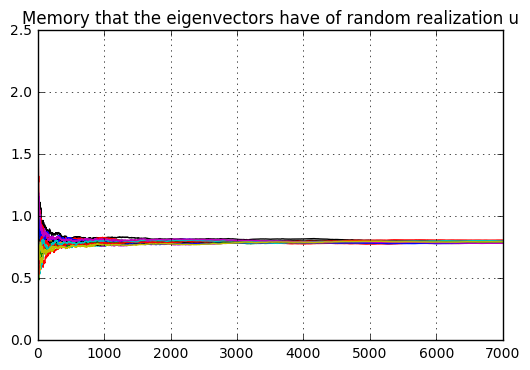

In [27]:
import numpy as n
import pylab as p
import capo.oqe as oqe

n.random.seed(0)
freqs=20
N_r = 7000 # number of realizations

num_colors = freqs
cm = p.get_cmap('nipy_spectral')
color_cnt = 0

# Covariance in Fourier Space
C_fourier = n.identity(freqs)
diagonal = n.linspace(1e5,1e1,freqs) # 4 orders of magnitude for steep eigenspectrum
C_fourier *= diagonal
_,Uf = n.linalg.eigh(C_fourier) # eigenvectors should be (1,0,0,0...), (0,1,0,0...), etc.
Uf = Uf[::-1]

# Covariance in Real Space (true covariance)
C_fft = n.zeros_like(C_fourier)
for col in range(C_fourier.shape[1]): # FFT on columns of C_fourier
    #C_fft[:][col] = n.fft.fft(C_fourier[:][col])
    C_fft[:][col] = C_fourier[:][col]
C_true = n.zeros_like(C_fft)
for col in range(C_fourier.shape[1]): # FFT on dagger of result
    #C_true[:][col] = n.fft.fft(n.conj(C_fft.T)[:][col])
    C_true[:][col] = n.conj(C_fft.T)[:][col]
C_true = n.conj(C_true.T) # dagger back
_,Ut = n.linalg.eigh(C_true)
Ut = Ut[::-1]

# Plot eigenvectors
p.figure(figsize=(8,4))
p.subplot(121)
for f in range(freqs):
    color = cm(1.*color_cnt/num_colors)
    p.plot(Uf[:][f],color=color,label=f)
    color_cnt += 1
p.title('Fourier Eigenvectors');p.ylim(-0.5,1.5);p.grid()
p.subplot(122)
color_cnt = 0
for f in range(freqs):
    color = cm(1.*color_cnt/num_colors)
    p.plot(Ut[:][f],color=color,label=f)
    color_cnt += 1
p.title('True Real-Space Eigenvectors');p.ylim(-0.5,1.5);p.grid()
p.show()

# Real space realizations
diffs = {}
for f in range(freqs): # create dictionary
    diffs[f] = []
x_combine = [] # combining as each realization is added
C_combine = []
stats_C = []
uv_combine = []
stats_uv = []
for r in range(N_r): # loop over realizations
    u = n.random.normal(scale=1,size=freqs)
    #x = n.fft.fft(n.sqrt(C_fourier.diagonal())*u)
    x = n.sqrt(C_fourier.diagonal())*u
    
    C_combine.append(n.outer(x,n.conj(x)))
    if r > 0: C_avg = n.mean(n.array(C_combine),axis=0)
    else: C_avg = n.outer(x,n.conj(x))
        
    _,Ur = n.linalg.eigh(C_avg) # eigenvector realization
    Ur = Ur[::-1]
    
    uv_combine.append(n.abs(n.dot(u,Ur))) # dot product of u with eigenvector
    if r > 0: uv_avg = n.mean(n.array(uv_combine),axis=0)
    else: uv_avg = n.abs(n.dot(u,Ur))
    stats_uv.append(uv_avg)
    
    stat_C = n.linalg.norm(C_true-C_avg)/n.linalg.norm(C_true) # convergence of covariance 
    stats_C.append(stat_C)
    
    for f in range(freqs): 
        #stat = n.min((n.mean(n.abs(Ut[:][f]-Ur[:][f])),n.mean(n.abs(Ut[:][f]+Ur[:][f])))) # convergence of eigenvectors
        stat = n.min((n.linalg.norm(Ut[:][f]-Ur[:][f]),n.linalg.norm(Ut[:][f]+Ur[:][f])))
        diffs[f].append(stat) 
#print n.array(diffs[0]).shape # index is first eigenvector, value is the difference

# Plot convergences
color_cnt = 0
for f in diffs.keys():
    color = cm(1.*color_cnt/num_colors)
    p.plot(n.arange(N_r),diffs[f],color=color,label=f, linewidth=1.5)
    color_cnt += 1
p.xlabel("Number of realizations", fontsize=14)
p.ylabel(r"Convergence level $\varepsilon(\hat\mathbf{{v}})$", fontsize=14)
p.legend(prop={'size':10},numpoints=1,loc='best',ncol=5,title="Eigenmode #")
p.tick_params(axis='both', which='major', labelsize=14)
p.yscale('log')
p.xscale('log')
p.xlim(freqs,N_r)
p.ylim(5e-7,5e0)
p.grid()
p.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_sigloss17.pdf',bbox_inches='tight') # manual save so labels don't get cut off??
p.show()

p.plot(n.arange(N_r),stats_C)
p.yscale('log')
p.xscale('log')
p.title('Covariance Convergence')
p.grid();p.show()

p.plot(n.arange(N_r),stats_uv)
p.grid()
p.title('Memory that the eigenvectors have of random realization u')
p.show()